In [ ]:
# ! for f in *.original.txt; do mv "$f" "$(echo "$f" | sed s/original\.txt/txt/)"; done

In [235]:
! mfa align --clean --config_path /mnt/home/v_baihe/data/LibriTTS/mfa/align.config /mnt/home/v_baihe/data/LibriTTS/mfa/wav_data/train-clean-100/ /mnt/home/v_baihe/data/librispeech-lexicon.txt english /mnt/home/v_baihe/data/LibriTTS/mfa/align_result/train-clean-100

All required kaldi binaries were found!
Cleaning old directory!
INFO - Setting up corpus information...
WARNING - Some issues parsing the corpus were detected. Please run the validator to get more information.
INFO - Number of speakers in corpus: 2, average number of utterances per speaker: 60.5
INFO - Parsing dictionary without pronunciation probabilities without silence probabilities
INFO - Creating dictionary information...
INFO - Setting up training data...
Generating base features (mfcc)...
Calculating CMVN...
INFO - Done with setup!
INFO - Performing first-pass alignment...
INFO - Calculating fMLLR for speaker adaptation...
INFO - Performing second-pass alignment...
INFO - Generating CTMs from alignment...
INFO - Finished generating CTMs!
INFO - Exporting TextGrids from CTMs...
INFO - Finished exporting TextGrids!
WARNING - There were 109 segments/files not aligned.  Please see /mnt/home/v_baihe/data/LibriTTS/mfa/align_result/train-clean-100/unaligned.txt for more details on why 

In [142]:
from espnet2.tasks.mlm import MLMTask
from espnet.nets.pytorch_backend.nets_utils import make_non_pad_mask
from espnet2.tasks.tts import TTSTask
from parallel_wavegan.utils import download_pretrained_model
from pathlib import Path
from espnet2.train.dataset import ESPnetDataset
from espnet2.tts.feats_extract.log_mel_fbank import LogMelFbank

import torch
import soundfile
import tgt
import string
import math
import numpy as np
from tqdm import tqdm

import IPython.display as ipd

def load_vocoder(vocoder_tag="parallel_wavegan/libritts_parallel_wavegan.v1"):
    vocoder_tag = vocoder_tag.replace("parallel_wavegan/", "")
    vocoder_file = download_pretrained_model(vocoder_tag)
    vocoder_config = Path(vocoder_file).parent / "config.yml"


    vocoder = TTSTask.build_vocoder_from_file(
                    vocoder_config, vocoder_file, None, 'cpu'
                )
    return vocoder

def load_mlm_model(config_path, model_path):
    mlm_model, args = MLMTask.build_model_from_file(config_file=config_path,
                                 model_file=model_path)
    return mlm_model, args

def get_time_span_to_edit(text_span_to_change, old_text, tgt_file):
    def get_alignment(tier, span, full_text):
        start_time = 0
        end_time = 0
        discard_part_left = full_text[:span[0]]
        discard_part_right = full_text[span[1]:]
        target_text = full_text[span[0]:span[1]]
        for t in tier._objects:
            s, e, p = t.start_time, t.end_time, t.text
            if not p:
                continue
            if discard_part_left and p == discard_part_left[:len(p)]:
                discard_part_left = discard_part_left[len(p):].strip()
            elif p == target_text[:len(p)]:
                target_text = target_text[len(p):].strip()
                if start_time==0:
                    start_time = s
                end_time = e
            else:
                return start_time, end_time
    textgrid = tgt.io.read_textgrid(tgt_file)
    start, end = get_alignment(
            textgrid.get_tier_by_name("words"), text_span_to_change, old_text.lower()
        )
    return (start, end)

In [298]:
def span_masking(sent_len):
    p=0.2
    min_span = 5
    max_span = 10
    len_distrib = [p * (1-p) ** (i - min_span) for i in range(min_span, max_span + 1)]
    len_distrib = [x / (sum(len_distrib)) for x in len_distrib]
    span_start = np.random.choice(sent_len)
    span_len = np.random.choice(np.arange(min_span, max_span+1), p=len_distrib)
    return span_start, span_len

In [367]:
def get_mlm_output(text_tobe_replaced, text_org, wav_org, vocoder, model_name ):
    config_path='/mnt/home/v_baihe/projects/espnet/egs2/an4/asr1/exp/{}/config.yaml'.format(exp_name)
    model_path = '/mnt/home/v_baihe/projects/espnet/egs2/an4/asr1/exp/{}/valid.loss.ave_10best.pth'.format(exp_name)
    mlm_model,args = load_mlm_model(config_path, model_path)

    text_org_no_punc = text_org.translate(str.maketrans('', '', string.punctuation))
    span_start = text_org_no_punc.index(text_tobe_replaced)
    span_end = span_start + len(text_tobe_replaced)

    text_span_to_change=(span_start,span_end)
    time_span = get_time_span_to_edit(text_span_to_change, text_org_no_punc, tgt_path)

    audio_span = (time_span[0]*args.feats_extract_conf['fs'], time_span[1]*args.feats_extract_conf['fs'])
    mel_span = (math.floor(audio_span[0]/args.feats_extract_conf['hop_length']),math.ceil(audio_span[1]/args.feats_extract_conf['hop_length']) )
    
    
    speech = torch.tensor(wav_org,dtype=torch.float).unsqueeze(0)
    speech_length = torch.tensor(len(wav_org)).unsqueeze(0)
    feats, feats_lengths = mlm_model.feats_extract(speech, speech_length)
    if mlm_model.normalize is not None:
        feats, feats_lengths = mlm_model.normalize(feats, feats_lengths)
    max_ilen = max(feats_lengths).item()
    round = max_ilen % mlm_model.encoder.attention_window
    if round != 0:
        max_ilen += (mlm_model.encoder.attention_window - round)
        n_batch = feats.shape[0]
        xs_pad = feats.new_zeros(n_batch, max_ilen, *feats[0].size()[1:])
        for i in range(n_batch):
            xs_pad[i, : feats[i].size(0)] = feats[i]
    else:
        xs_pad = feats[:, : max_ilen]
    src_mask = make_non_pad_mask(feats_lengths.tolist(), xs_pad[:,:,0], length_dim=1).to(xs_pad.device).unsqueeze(-2)

    masked_position = np.zeros((xs_pad.shape[0], xs_pad.shape[1]))
    # span_start, span_len = span_masking(mel_span[1]-mel_span[0])
    span_start = 5
    span_len = 10
    span_start = mel_span[0]+span_start
    masked_position[:,span_start:span_start+span_len] = 1
    span_start = 30
    span_len = 10
    span_start = mel_span[0]+span_start
    masked_position[:,span_start:span_start+span_len] = 1
    masked_position = torch.BoolTensor(masked_position).to(xs_pad.device)
    batch = dict(
                xs_pad=xs_pad,
                ilens=feats_lengths,
                masked_position=masked_position,
                attention_mask=src_mask,
            )
    encoder_out, encoder_out_lens, _ = mlm_model.encoder(**batch)
    output = mlm_model.sfc(encoder_out)
    input_feat = output.squeeze().cpu()[:encoder_out_lens[0],:]
    un_filled_masked_feat = mlm_model.encoder.embed[0](output, masked_position).squeeze()[mel_span[0]:mel_span[1],:]
    masked_feat = input_feat[mel_span[0]:mel_span[1],:]
    full_wav = vocoder(input_feat)
    masked_wav = vocoder(masked_feat)
    unfilled_masked_wav = vocoder(un_filled_masked_feat)
#     xs_pad.squeeze().
#     replaced_wav = vocoder()
#     replaced_wav
    return (full_wav, masked_wav,unfilled_masked_wav), (xs_pad.squeeze()[mel_span[0]:mel_span[1],:],masked_feat,un_filled_masked_feat)

In [295]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [ ]:
vocoder = load_vocoder()

In [272]:
file_name = "1272_128104_000003_000001"
#file_name = "1272_128104_000005_000000"
wav_path = "/mnt/home/v_baihe/data/LibriTTS/dev-clean/1272/128104/{}.wav".format(file_name)
text_path = "/mnt/home/v_baihe/data/LibriTTS/dev-clean/1272/128104/{}.original.txt".format(file_name)
tgt_path = "/mnt/home/v_baihe/data/LibriTTS/mfa/align_result/dev-clean/1272/128104/{}.TextGrid".format(file_name)

text_org = open(text_path,'r').readline().strip()
print(text_org)
wav_org, rate = soundfile.read(
                wav_path, always_2d=False)
ipd.Audio(torch.tensor(wav_org).float().data.cpu().numpy(), rate=24000)

Mr. Quilter is entirely free from affectation of any kind.


In [325]:
exp_name = "mlm_prob0.25"
#  mlm_train_mlm_raw_en_bpe5000
config_path='/mnt/home/v_baihe/projects/espnet/egs2/an4/asr1/exp/{}/config.yaml'.format(exp_name)
model_path = '/mnt/home/v_baihe/projects/espnet/egs2/an4/asr1/exp/{}/valid.loss.ave_10best.pth'.format(exp_name)
mlm_model,args = load_mlm_model(config_path, model_path)

/mnt/home/v_baihe/anaconda3/envs/espnet2/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [382]:
text_tobe_replaced = 'affectation'

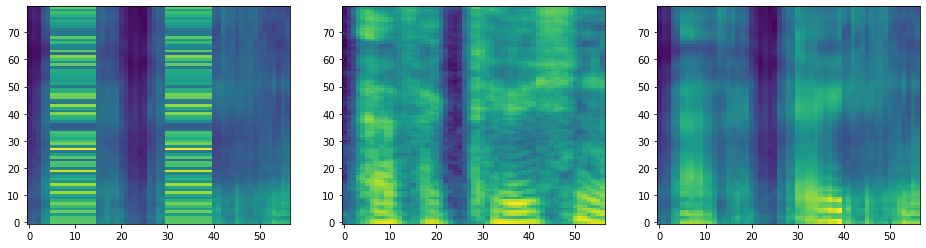

In [383]:
model_name = "mlm_prob0.25"
(new_wav, masked_wav,unfilled_masked_wav),\
(ground_truth_spec, filled_masked_spec, unfilled_masked_spec)\
= get_mlm_output(text_tobe_replaced, text_org, wav_org, vocoder, model_name )

plot_data((unfilled_masked_spec.float().data.cpu().numpy().T,
          ground_truth_spec.float().data.cpu().numpy().T,
          filled_masked_spec.float().data.cpu().numpy().T,))

In [387]:
ipd.Audio(new_wav.detach().float().data.cpu().numpy(), rate=24000)

In [385]:
ipd.Audio(masked_wav.detach().float().data.cpu().numpy(), rate=24000)

In [386]:
ipd.Audio(unfilled_masked_wav.detach().float().data.cpu().numpy(), rate=24000)

In [371]:
model_name = "mlm_train_mlm_raw_en_bpe5000"
(new_wav, masked_wav,unfilled_masked_wav),\
(ground_truth_spec, filled_masked_spec, unfilled_masked_spec)\
= get_mlm_output(text_tobe_replaced, text_org, wav_org, vocoder, model_name )

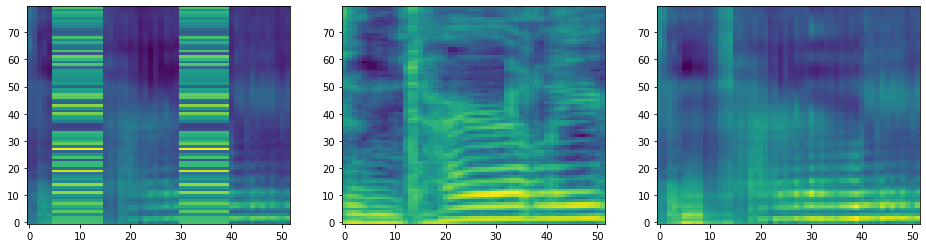

In [372]:
plot_data((unfilled_masked_spec.float().data.cpu().numpy().T,
          ground_truth_spec.float().data.cpu().numpy().T,
          filled_masked_spec.float().data.cpu().numpy().T,))

In [364]:
ipd.Audio(new_wav.detach().float().data.cpu().numpy(), rate=24000)

In [373]:
ipd.Audio(masked_wav.detach().float().data.cpu().numpy(), rate=24000)

In [374]:
ipd.Audio(unfilled_masked_wav.detach().float().data.cpu().numpy(), rate=24000)

In [189]:
args.distributed=False

In [237]:
from espnet2.train.distributed_utils import DistributedOption
from espnet2.utils.build_dataclass import build_dataclass
distributed_option = build_dataclass(DistributedOption, args)
distributed_option.init_options()
_rank = ""
distributed_option.init_torch_distributed()
train_iter_factory = MLMTask.build_iter_factory(
                    args=args,
                    distributed_option=distributed_option,
                    mode="valid",)

In [238]:
iterator=train_iter_factory.build_iter(0)

In [202]:
feat_max

1.2678672075271606

In [203]:
feat_min

-6.074887275695801

In [248]:
file_names = []
for batch in tqdm(iterator):
    file_names.extend(batch[0])

100%|███████████████████████████████████████████████████████| 222/222 [00:01<00:00, 142.86it/s]


In [252]:
[x for x in file_names if "1272_" in x]

['1272_141231_000026_000000',
 '1272_135031_000045_000002',
 '1272_141231_000034_000003',
 '1272_141231_000031_000002',
 '1272_128104_000005_000000',
 '1272_141231_000024_000002',
 '1272_141231_000019_000001']

In [247]:
file_name

'1272_128104_000003_000001'

In [246]:
batch

[['6313_66125_000007_000001',
  '6313_76958_000079_000000',
  '8842_304647_000013_000000'],
 {'speech': tensor([[-1.1932e-02,  1.5015e-02, -5.0049e-03,  ...,  3.6621e-04,
           -4.5776e-04, -8.2397e-04],
          [ 2.1362e-04,  6.4087e-04,  1.3428e-03,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-1.5259e-04, -3.0518e-05, -1.8311e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]),
  'speech_lengths': tensor([13920, 12720, 10320])}]

In [243]:
file_name

'1272_128104_000003_000001'

In [ ]:
file_name = batch[0][0]
wav_path = "/mnt/home/v_baihe/data/LibriTTS/train-clean-100/2182/181173/{}.wav".format(file_name)
text_path = "/mnt/home/v_baihe/data/LibriTTS/train-clean-100/2182/181173/{}.original.txt".format(file_name)
tgt_path = "/mnt/home/v_baihe/data/LibriTTS/mfa/align_result/train-clean-100/2182/181173/{}.TextGrid".format(file_name)

text_org = open(text_path,'r').readline().strip()
print(text_org)
wav_org, rate = soundfile.read(
                wav_path, always_2d=False)
ipd.Audio(torch.tensor(wav_org).float().data.cpu().numpy(), rate=24000)

In [219]:
speech = batch[1]['speech'][0].unsqueeze(0)
speech_length = batch[1]['speech_lengths'][0].unsqueeze(0)
feats, feats_lengths = mlm_model.feats_extract(speech, speech_length)
if mlm_model.normalize is not None:
    feats, feats_lengths = mlm_model.normalize(feats, feats_lengths)
max_ilen = max(feats_lengths).item()
round = max_ilen % mlm_model.encoder.attention_window
if round != 0:
    max_ilen += (mlm_model.encoder.attention_window - round)
    n_batch = feats.shape[0]
    xs_pad = feats.new_zeros(n_batch, max_ilen, *feats[0].size()[1:])
    for i in range(n_batch):
        xs_pad[i, : feats[i].size(0)] = feats[i]
else:
    xs_pad = feats[:, : max_ilen]
src_mask = make_non_pad_mask(feats_lengths.tolist(), xs_pad[:,:,0], length_dim=1).to(xs_pad.device).unsqueeze(-2)

masked_position = np.zeros((xs_pad.shape[0], xs_pad.shape[1]))
masked_position[:,mel_span[0]:mel_span[1]] = 1
masked_position = torch.BoolTensor(masked_position).to(xs_pad.device)
batch = dict(
            xs_pad=xs_pad,
            ilens=feats_lengths,
            masked_position=masked_position,
            attention_mask=src_mask,
        )

encoder_out, encoder_out_lens, _ = mlm_model.encoder(**batch)
input_feat = mlm_model.sfc(encoder_out).squeeze().cpu()[:encoder_out_lens[0],:]
masked_feat = input_feat[masked_position.squeeze()[:encoder_out_lens[0]]]
full_wav = vocoder(input_feat)
masked_wav = vocoder(masked_feat)

TypeError: MLMTransformerEncoder object argument after ** must be a mapping, not list